### Discription: Fashion Mnist 图像分类

In [1]:
import os
import gzip
import numpy as np
from PIL import Image

import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [2]:
class FashionDataset(Dataset):
    '''
    定义Dataset:
    - 用于加载训练和测试数据，请勿改动
    - 返回一张图片(3维Tensor)以及对应的标签(0-9)
    '''
    def __init__(self,datadir,transform,is_train = True):
        super().__init__()
        self.datadir = datadir
        self.img,self.label = self.load_data(self.datadir,is_train = is_train)
        self.len_data = len(self.img)
        self.transform = transform
        
    def __getitem__(self,index):
        return self.transform(self.img[index]), self.label[index]
    
    def __len__(self):
        return self.len_data
    
    def load_data(self,datadir,is_train):
        dirname = os.path.join(datadir)
        files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
            't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

        paths = []
        for fname in files:
            paths.append(os.path.join(dirname,fname))
        if is_train:

            with gzip.open(paths[0], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)
            with gzip.open(paths[1], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                   offset=16).reshape(len(label), 28, 28)
        else:
            with gzip.open(paths[2], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)

            with gzip.open(paths[3], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                      offset=16).reshape(len(label), 28, 28)
        return img, label

In [3]:
class FashionMnistModel(nn.Module):
    def __init__(self):
        '''
        ***********请在此写入你的代码**********
        定义模型
        '''

    def forward(self, x):
        '''
        *********请在此处输入你的代码*********
        输入：input, 它的size是(batch_size, img_c, img_h, img_w)
        输出（返回值）：output(预测值)，hidden(隐藏层的值)
            * output的size是(batch_size, num_label)
            
        定义模型函数：
            * 将输入经过卷积层和激活函数
            * 使用pooling降低通道数
            * 对卷积层的输出做适当的维度变换
            * 用线性层将output映射到num_label的维度上
            * 返回output
        '''


In [4]:
class Model():
    def __init__(self):
        '''
        创建模型和优化器，设置模型超参数
        * 参数
            * learning_rate
            * epoches
            * model_save_path
            * device: cuda or cpu
        * 模型
            * 创建FashionMnistModel的实例，命名为model
            * 定义optimizer
            * 定义loss function
        '''
        self.lr = 0.01
        self.epoches = 20
        self.model_save_path = './model'
        # 指定训练的device，优先使用GPU，GPU不可用时加载CPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
        self.model = FashionMnistModel().to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_function = nn.CrossEntropyLoss()
    def _save_model(self, epoch):
        """
        保存模型，用于训练时保存指定epoch的模型
        """
        print('[INFO] Saving to %s/%s.pth' % (self.model_save_path, epoch))
        torch.save(self.model.state_dict(), '%s/%s.pth' % (self.model_save_path, epoch))
        
    def _load_model(self, epoch):
        """
        加载模型，用于加载指定epoch的模型。
        目前代码中没有用到。
        可以在训练到一半但中断了之后，自行修改代码，从最近的epoch加载，然后继续训练，以节省时间。
        或者训练完毕后，下次再跑程序，就直接加载模型，省去训练时间。
        """
        print('[INFO] Loading from %s_%s.pth' % (self.model_save_path, epoch))
        self.model.load_state_dict(torch.load('%s/%s.pth' % (self.model_save_path, epoch), map_location=self.device))
        
    def train(self,train_loader,test_loader):
        '''
        训练函数
        '''
        
        for epoch in range(self.epoches):
            loss_list = []
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(self.device), target.long().to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.loss_function(output, target)
                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                if batch_idx % 50 == 0:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                               100. * batch_idx / len(train_loader), loss.item()))
            self.test(test_loader)
            # 保存模型参数
            if (epoch+1) % 5 == 0:
                self._save_model(epoch+1)
    def test(self,test_loader):
        '''
        检验模型测试集上的效果
        '''
        
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(self.device), target.long().to(self.device)
                output = self.model(data)
                test_loss += self.loss_function(output, target).item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [5]:
# 定义data loader
train_dataset = FashionDataset('data',
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                         ])
                        )
                             
train_loader = DataLoader(train_dataset,batch_size=320, shuffle=True, num_workers=0)

test_dataset = FashionDataset('data',
                         transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                         ]),
                        is_train = False
                        )
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False, num_workers=0)


In [6]:
model = Model()
# 模型训练
model.train(train_loader, test_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.411721
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.657743
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.458249
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.509745

Test set: Average loss: 0.0190, Accuracy: 7977/10000 (80%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.554021
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.452995
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.399422
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.451465

Test set: Average loss: 0.0160, Accuracy: 8273/10000 (83%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.583947
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.377678
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.315062
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.388187

Test set: Average loss: 0.0217, Accuracy: 7774/10000 (78%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.671110
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.485531
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.635712
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.458330

Test set: Average loss: 0.0175, Accu

In [7]:
model2 = FashionMnistModel()
# 加载权重
state_dict = torch.load("./model/15.pth")
model2.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
model2

In [9]:
label_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [10]:
def inference(model,img):
    model.eval()
    img = img.unsqueeze(dim = 0)
    output = model(img)
    pred = output.argmax(dim=1, keepdim=True)
    return pred.squeeze().numpy()

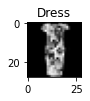

In [11]:
img,label = test_dataset.__getitem__(100)
pred = inference(model2,img)
fig = plt.figure(figsize=(1,1))
plt.title(label_classes[pred])
plt.imshow(np.squeeze(img), cmap='gray')
